In [44]:
import pandas as pd
import numpy as np
from influxdb import InfluxDBClient
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.parser import parse
from dateutil import tz

sns.set(style="whitegrid")
sns.set(font_scale=0.7)

In [75]:
class InfluxDB:
    def __init__(self, url: str, port: int, username: str, password: str,
                 basestations: list, beacon: str, classification: str,
                 startdatetime: str = None, enddatetime: str = None):
        self.client = InfluxDBClient(url, port, username, password)
        self.basestations = basestations
        self.beacon = beacon
        self.classification = classification
        self.timefilter = '1=1'
        self.timefilter += f"\n\t\tAND time >= '{InfluxDB.convert_to_rfc3339(startdatetime)}'" if startdatetime else ''
        self.timefilter += f"\n\t\tAND time <= '{InfluxDB.convert_to_rfc3339(enddatetime)}'" if enddatetime else ''

    @property
    def df_basestation_beacon_values(self):
        where = ''.join([f"\n\t\t    OR entity_id = 'mqtt_{self.beacon}_{basestation}_raw'" for basestation in self.basestations])
        query = f'''
            SELECT friendly_name_str as basestation, value as distance
            FROM homeassistant.autogen.m
            WHERE {self.timefilter}
                AND (
                    1<>1 {where}
                )
        '''
        df = pd.DataFrame(self.client.query(query).get_points())
        df.time = pd.to_datetime(df.time)
        return df

    @property
    def df_classifications(self):
        query = f'''
            SELECT state as y
            FROM homeassistant.autogen.state
            WHERE {self.timefilter}
                AND entity_id = '{self.classification}'
        '''
        df = pd.DataFrame(self.client.query(query).get_points())
        df.time = pd.to_datetime(df.time)
        return df

    def get_Xy(self):
        self.df = (
            pd.concat([self.df_basestation_beacon_values, self.df_classifications], axis=0)
            .pivot(index=['time', 'y'], columns='basestation', values='distance')
            .fillna(method='ffill')
            .reset_index('y')
            .fillna(method='ffill')
            .drop(np.nan, axis=1)
            .dropna()
            .query('y != "None"')
        )
        self.X = self.df.drop('y', axis=1)
        self.y = self.df.y
        return self.X, self.y

    def show_basestation_strength(self):
        fig, ax = plt.subplots(3, figsize=(10, 3), sharex=True, sharey=True)
        data = self.df_basestation_beacon_values
        for i, basestation in enumerate(data.basestation.unique()):
            sns.lineplot(
                data=data.loc[data.basestation == basestation],
                x='time', y='distance',
                linewidth=0.5, ax=ax[i]
            ).set_title(basestation)
        plt.show()

    @staticmethod
    def convert_to_rfc3339(date_string):
        dt = parse(date_string)
        dt = dt.astimezone(tz.UTC)
        return dt.strftime('%Y-%m-%dT%H:%M:%SZ')

influx = InfluxDB(
    url='192.168.50.134',
    port=8086,
    username='homeassistant',
    password='homeassistant',
    basestations=['office', 'livingroom', 'bedroomjk'],
    beacon='iphonejd',
    classification='jd_iphone_room_training_data',
    startdatetime='2023-07-17T21:51:00',
)

X, y = influx.get_Xy()
print(y.value_counts())

y
LivingRoom    207
Hallway0      124
BedroomJK     115
DiningRoom    106
Hallway1      103
Playroom       98
Hallway2       93
Office         86
BedroomS       78
BedroomCC      74
Kitchen        73
Name: count, dtype: int64


In [135]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
scores = cross_val_score(lr, X, y, cv=StratifiedKFold(n_splits=5))
print("Cross-validation accuracy scores:", scores)
print("Mean cross-validation accuracy:", scores.mean())

Cross-validation accuracy scores: [0.56465517 0.56465517 0.66233766 0.62770563 0.62770563]
Mean cross-validation accuracy: 0.6094118525153008


0.6
              precision    recall  f1-score   support

   BedroomCC       0.65      0.77      0.71        22
   BedroomJK       0.83      0.87      0.85        23
    BedroomS       0.62      0.65      0.64        23
  DiningRoom       0.59      0.33      0.43        30
    Hallway0       0.45      0.52      0.48        25
    Hallway1       0.26      0.35      0.30        26
    Hallway2       0.50      0.40      0.44        25
     Kitchen       0.50      0.65      0.56        17
  LivingRoom       0.83      0.74      0.78        61
      Office       0.75      0.82      0.78        22
    Playroom       0.38      0.38      0.38        16

    accuracy                           0.60       290
   macro avg       0.58      0.59      0.58       290
weighted avg       0.61      0.60      0.60       290



<Axes: >

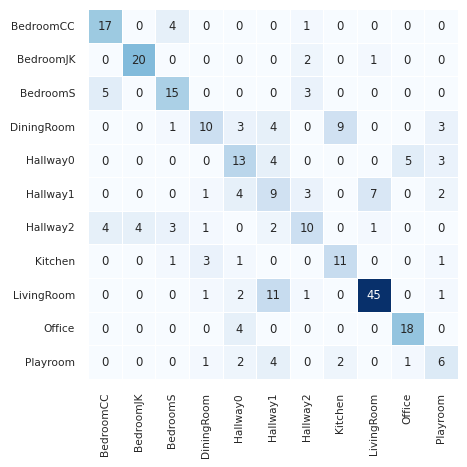

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(
    data=confusion_matrix(y_test, y_pred),
    annot=True, fmt='d', cbar=False, square=True,
    linecolor='white', linewidths=0.5, cmap='Blues',
    xticklabels=lr.classes_,
    yticklabels=lr.classes_,
)

In [178]:
lr.fit(X, y)
print(lr.score(X_test, y_test))

0.6241379310344828


In [177]:
def write_yaml(coef, intercept, classes, device):
    x_variables = '\n    '.join(
        [f"{{% set x{i+1} = states('sensor.mqtt_{device.lower()}_{classes[i].lower()}_raw') | float %}}"
         for i in range(coef.shape[1])])
    logits = ', '.join(
        [f"\n\t{intercept[i].round(8)} " + ' '.join(
        [f"+ x{j+1} * {coef[i, j].round(8)}"
         for j in range(coef.shape[1])])
         for i in range(len(classes))])
    return f"""- name: "ESPresense-ML {device} Prediction Class"
  unique_id: espresense-ml_{device.lower()}_predictionclass
  state: >
    {{% set classes = {str(classes.tolist())} %}}
    {x_variables}
    {{% set logits = [{logits}] %}}
    {{{{classes[logits.index(logits | max)]}}}}"""

print(write_yaml(lr.coef_, lr.intercept_, lr.classes_, 'iPhoneJD'))

- name: "ESPresense-ML iPhoneJD Prediction Class"
  unique_id: espresense-ml_iphonejd_predictionclass
  state: >
    {% set classes = ['BedroomCC', 'BedroomJK', 'BedroomS', 'DiningRoom', 'Hallway0', 'Hallway1', 'Hallway2', 'Kitchen', 'LivingRoom', 'Office', 'Playroom'] %}
    {% set x1 = states('sensor.mqtt_iphonejd_bedroomcc_raw') | float %}
    {% set x2 = states('sensor.mqtt_iphonejd_bedroomjk_raw') | float %}
    {% set x3 = states('sensor.mqtt_iphonejd_bedrooms_raw') | float %}
    {% set logits = [
	-7.21666117 + x1 * -2.00739861 + x2 * 2.20753011 + x3 * 1.62899311, 
	6.00869394 + x1 * -3.92621473 + x2 * 0.02780705 + x3 * 1.30374058, 
	-6.58901218 + x1 * -0.69330269 + x2 * 1.56390339 + x3 * 1.50687492, 
	-5.11943351 + x1 * 1.56616396 + x2 * 0.14506183 + x3 * 0.58613636, 
	2.2087707 + x1 * 1.5404078 + x2 * -0.18083526 + x3 * -1.73506279, 
	4.58455542 + x1 * 0.8908334 + x2 * -1.86802895 + x3 * -0.04556443, 
	5.47424413 + x1 * -2.05891012 + x2 * 0.14588166 + x3 * 0.78526619, 
	-10.3

In [182]:
import paho.mqtt.client as mqtt
import json

verbose = False

X_live = {
    'espresense/devices/jd_iphone/bedroomjk': 0.,
    'espresense/devices/jd_iphone/livingroom': 0.,
    'espresense/devices/jd_iphone/office': 0.,
}

def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    client.subscribe("espresense/devices/jd_iphone/bedroomjk")
    client.subscribe("espresense/devices/jd_iphone/office")
    client.subscribe("espresense/devices/jd_iphone/livingroom")

def on_message(client, userdata, msg):
    data = json.loads(msg.payload)
    if 'raw' in data:
        X_live[msg.topic] = data['raw']
        X = pd.DataFrame(
            X_live.values(),
            index=['MQTT iPhoneJD BedroomJK Raw', 'MQTT iPhoneJD LivingRoom Raw', 'MQTT iPhoneJD Office Raw']
        ).T
        pred = lr.predict_proba(X)[0]
        pred_class, prob = lr.classes_[pred.argmax()], pred.max()
        print(f"Class: {pred_class}, Probability: {prob}")

client = mqtt.Client()
client.username_pw_set("mqtt-user", "vlmSDF543")
client.on_connect = on_connect
client.on_message = on_message
client.connect("192.168.50.134", 1883, 60)
client.loop_forever()

Connected with result code 0
Class: BedroomJK, Probability: 0.5204865318464751
Class: BedroomJK, Probability: 0.8633151279800031
Class: Hallway2, Probability: 0.7412604297826576
Class: Hallway2, Probability: 0.7766717532382585
Class: Hallway2, Probability: 0.7559388842811804
Class: Hallway2, Probability: 0.7559388842811804
Class: Hallway2, Probability: 0.725667439674693
Class: LivingRoom, Probability: 0.5716624611624336
Class: LivingRoom, Probability: 0.677616770410229
Class: LivingRoom, Probability: 0.6973321038024967
Class: LivingRoom, Probability: 0.71963391058793
Class: Hallway1, Probability: 0.40776573495460877
Class: Hallway1, Probability: 0.40776573495460877
Class: Hallway1, Probability: 0.3731902966373693
Class: LivingRoom, Probability: 0.6082709341199761
Class: LivingRoom, Probability: 0.5960068203611594
Class: LivingRoom, Probability: 0.6789861207194339
Class: LivingRoom, Probability: 0.7585337067887605
Class: LivingRoom, Probability: 0.7199720041202265
Class: LivingRoom, Pro

KeyboardInterrupt: 